# Topic 3 - Basic Time Series Methods

 

## Overview

 

This third topic covers the peculiarities of working with time series,

as opposed to cross-sectional data, i.e. "why the time dimension is special".

 

## Learning Materials

 

1. Read through [FPP3 Chapter 5](https://otexts.com/fpp3/toolbox.html) (Ch. 4 will be used later).

 

2. Read this [review paper on arxiv](https://arxiv.org/pdf/2104.00164.pdf), parts 1-3.

   Most of this will just be review for you, too.

 

3. Read [FPP Section 13.6](https://otexts.com/fpp3/backcasting.html) and

   this [paper on backtesting in time series](https://arxiv.org/pdf/1905.11744.pdf).

 

## Tasks

 

1. [Chapter 5 Exercises](https://otexts.com/fpp3/toolbox-exercises.html) from FPP3, using the data from the `py_tsdata` package.

 

2. Follow along with this [Residual Diagnostics example](https://www.mathworks.com/help/econ/time-series-regression-vi-residual-diagnostics.html)

   from the MATLAB docs with any dataset you've previously worked with.

   For the models to compare, use the naive method (random walk) and seasonal decomposition.

## Solutions

### FPP Problems - Solutions


In [27]:
# np and pandas
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.stats import shapiro, jarque_bera

# loading ts data
from tsdata.raw import load_data

# set style of plots
plt.style.use('Solarize_Light2')


1. Produce forecasts for the following series using whichever of NAIVE(y), SNAIVE(y) or RW(y ~ drift()) is more appropriate in each case:

- Australian Population (global_economy)
- Bricks (aus_production)
- NSW Lambs (aus_livestock)
- Household wealth (hh_budget).
- Australian takeaway food turnover (aus_retail).

<AxesSubplot:xlabel='Year'>

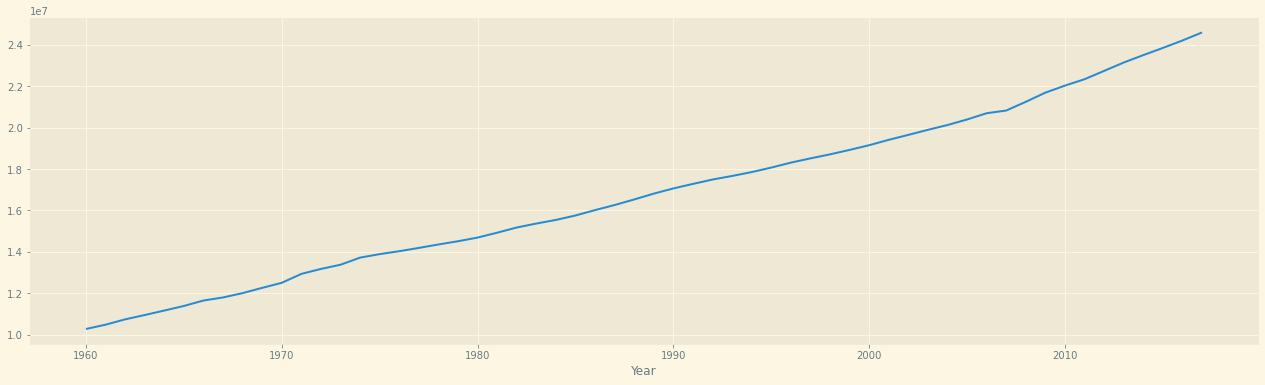

In [4]:
global_economy_df = load_data("global_economy")
population_ts = global_economy_df[global_economy_df.Code == "AUS"].set_index('Year').Population

population_ts.plot(figsize=(22, 6))

For this one we can use a naive method of using the trend in the last two values.

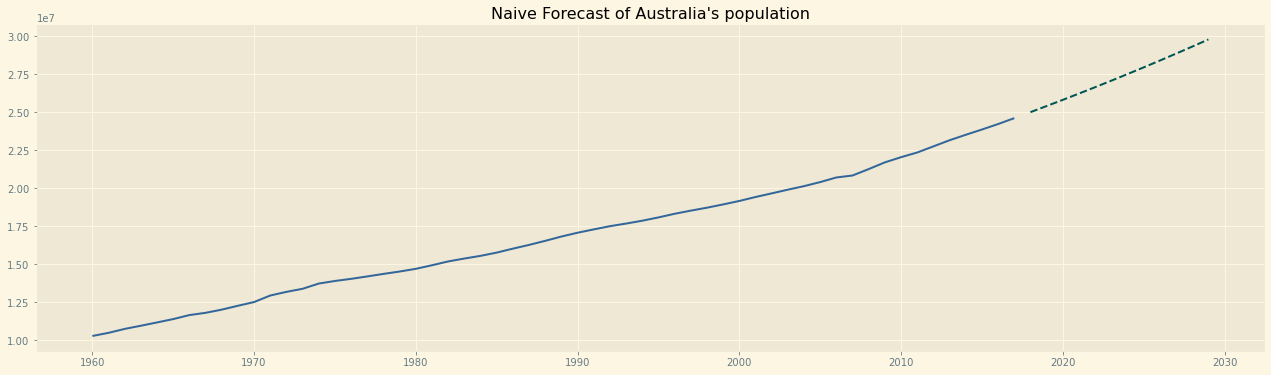

In [5]:
FORECAST_H = 12
last_value = population_ts.values[-1]
last_date = population_ts.index[-1]

# produce the forecast series
slope = last_value / population_ts.values[-2]
forecast_ts = pd.Series(
    data = slope ** np.arange(1, FORECAST_H + 1) * last_value,
    index = [last_date + i for i in range(1, FORECAST_H + 1)]
)

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series of Australia's population
ax.plot(population_ts, color="#336699")
ax.set_title("Naive Forecast of Australia's population")

# plot the forecasts for the future 12 periods using the naive method
ax.plot(forecast_ts, "--", color="#005555")


2. Use the Facebook stock price (data set gafa_stock) to do the following:
- Produce a time plot of the series.
- Produce forecasts using the drift method and plot them.
- Show that the forecasts are identical to extending the line drawn between the first and last observations.
- Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?

In [6]:
gafa_stock_df = (load_data("gafa_stock")
 .assign(Date=lambda df: pd.to_datetime(df.Date))
 .set_index('Date')
)

#### Drift method

$$
\hat{y}_{T+h|T} = y_T + \frac{h}{T - 1}\sum_{t=2}^T{y_t-y_{t-1}}=y_T+h(\frac{y_T-y_1}{T-1})
$$

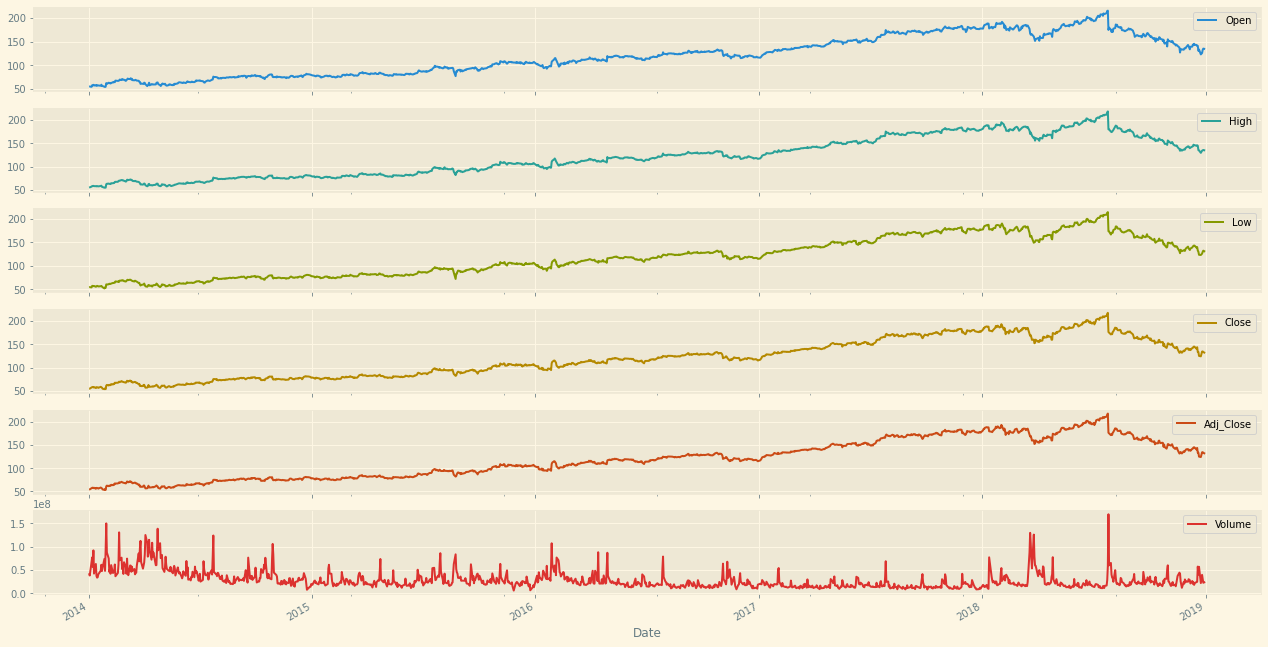

In [7]:
gafa_stock_df[gafa_stock_df.Symbol == "FB"].plot(subplots=True, figsize=(22, 12))
fb_stock_df = gafa_stock_df[gafa_stock_df.Symbol == "FB"]
fb_open_ts = fb_stock_df.Open

Text(0.5, 1.0, 'Facebook Open stock price')

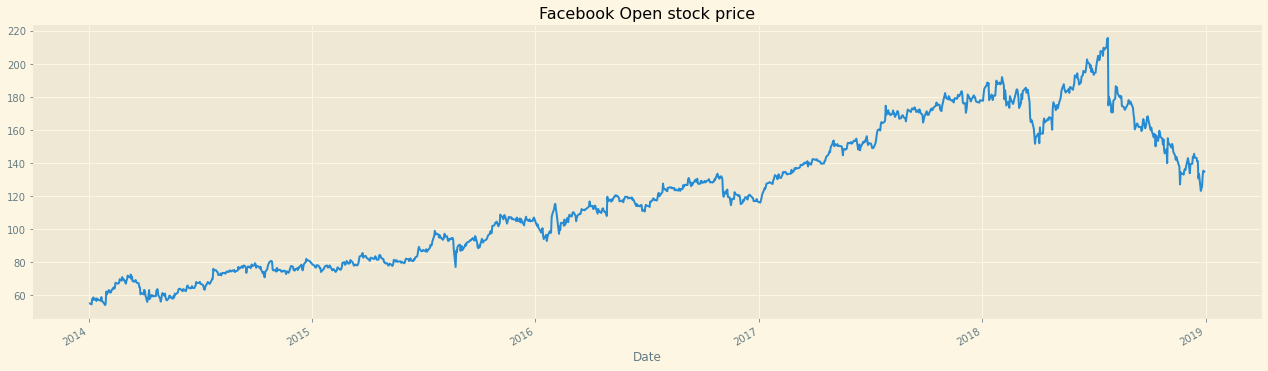

In [8]:
ax = fb_open_ts.plot(figsize=(22, 6))
ax.set_title("Facebook Open stock price")

2019-01-01    134.513187
2019-01-02    134.576377
2019-01-03    134.639567
2019-01-04    134.702758
2019-01-05    134.765948
                 ...    
2019-12-27    157.261635
2019-12-28    157.324825
2019-12-29    157.388015
2019-12-30    157.451205
2019-12-31    157.514395
Length: 365, dtype: float64

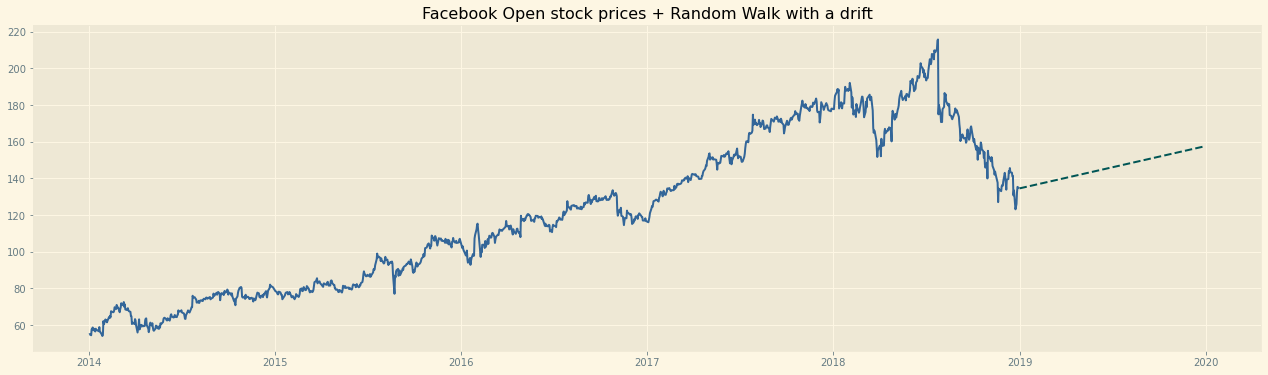

In [9]:
from datetime import timedelta

def drift_forecast(series, h):
    last_value = series.values[-1]
    T = series.shape[0]
    return last_value + h * (last_value - series.values[1]) / (T - 1)

FORECAST_H = 365

last_date = fb_open_ts.index.max()

forecast_ts = pd.Series(
    data=[drift_forecast(fb_open_ts, h) for h in range(1, FORECAST_H + 1)],
    index=[last_date + timedelta(days=i) for i in range(1, FORECAST_H + 1)]
)

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series of Australia's population
ax.plot(fb_open_ts, color="#336699")
ax.set_title("Facebook Open stock prices + Random Walk with a drift")

# plot the forecasts for the future 12 periods using the naive method
ax.plot(forecast_ts, "--", color="#005555")
forecast_ts


### Residual Diagnostics

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


Text(0, 0.5, 'employment (in milions)')

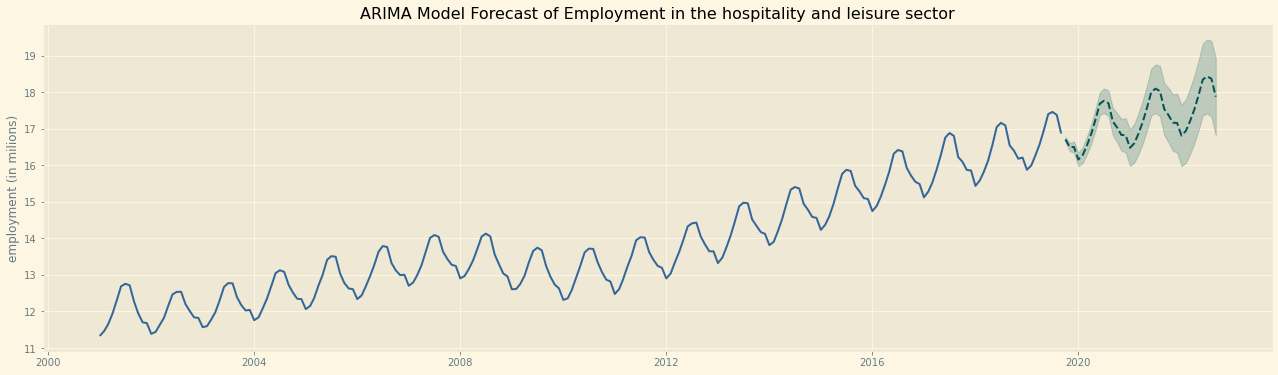

In [10]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

us_employment_df = load_data("us_employment").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
).set_index("Date")

is_leisure = us_employment_df.Title == "Leisure and Hospitality"
is_after_2000 = us_employment_df.Year > 2000

us_leisure_df = us_employment_df[is_leisure & is_after_2000]
leisure_ts = us_leisure_df.Employed / 1000

FORECAST_H = 36
N = leisure_ts.shape[0]
last_date = leisure_ts.index.max()

final = ARIMA(endog=leisure_ts, order=(2, 1, 0), seasonal_order=(1, 1, 1, 12)).fit()
forecast_df = final.get_forecast(FORECAST_H).summary_frame()

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series
ax.plot(leisure_ts, color="#336699")
ax.set_title("ARIMA Model Forecast of Employment in the hospitality and leisure sector")

# plot the forecasts for the future 12 periods
ax.plot(forecast_df.index, forecast_df["mean"], "--", color="#005555")
ax.fill_between(forecast_df.index, forecast_df["mean_ci_lower"], forecast_df["mean_ci_upper"], alpha=0.2, color="#005555")

ax.set_ylabel("employment (in milions)")

<AxesSubplot:xlabel='Date'>

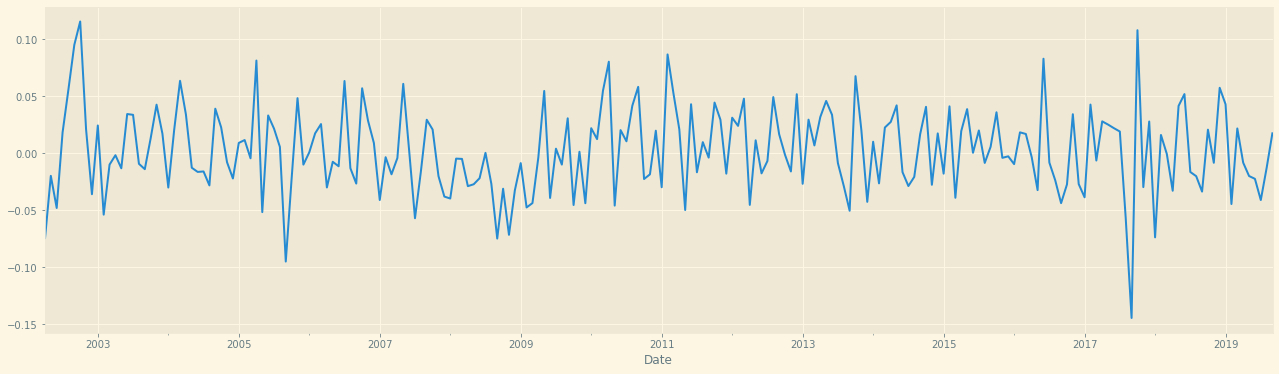

In [21]:
resids = final.resid[15:]
resids.plot(figsize=(22, 6))

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_22471/1114829254.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


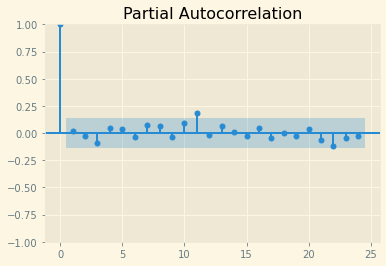

In [25]:
plot_pacf(resids).show()

In [28]:
acorr_ljungbox(resids, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,5.795803,0.832117,5.579954,0.849234


In [29]:
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
durbin_watson(resids)


1.9319357106140795

Econometricians have traditionally relied on a rule of thumb that a Durbin-Watson statistic below about 1.5 is reason to suspect positive first-order autocorrelation. 

#### Heteroscedasticity

- Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH).
    - It assesses the null hypothesis that a series of residuals $r_t$ exhibits no conditional heteroscedasticity (ARCH effects)



In [40]:
from statsmodels.stats.diagnostic import het_arch

_, lm_pval, _, fpval = het_arch(resids)
# some of the observations are outliers and that's why we get a 
print(lm_pval, fpval)

0.5890930115923645 0.6030124226993168


### Normality?

In [55]:
shapiro(resids)
shapiro(resids[15:100])


ShapiroResult(statistic=0.9910620450973511, pvalue=0.8326041102409363)

In [45]:
jarque_bera(resids)

Jarque_beraResult(statistic=5.4259892652624835, pvalue=0.06633785147006677)

<AxesSubplot:ylabel='Density'>

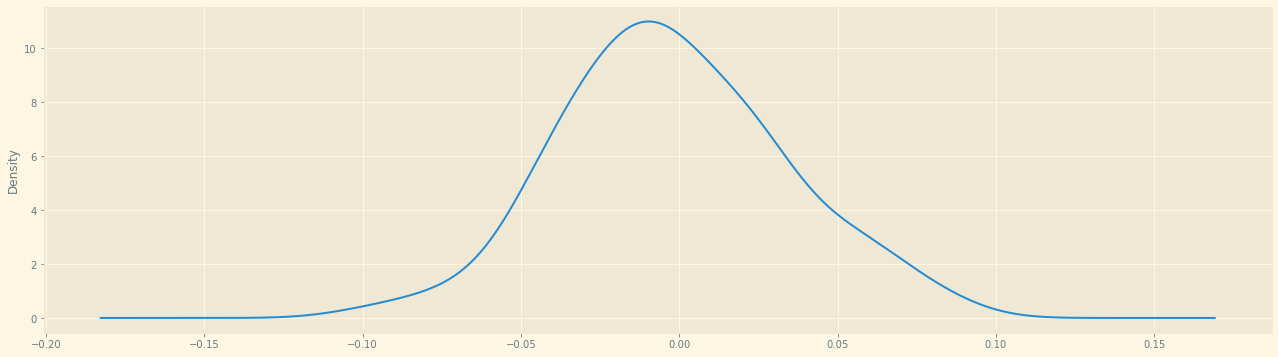

In [53]:
resids[15:100].plot.density(figsize=(22, 6))

Again, most of the residuals are normally distributed, but some are outlers and affecting the distribution quite a lot.



### 3. Take the following Kaggle dataset: [Nepalese Large Cardamom Forecasting Data](https://www.kaggle.com/shashwatwork/nepalese-large-cardamom-forecasting-data?select=combined_data.csv) (combined_data.csv).

   Tidy up the data. Devise a validation scheme for prediction, including actually splitting the dataset.

   Use an average as your forecast method. Calculate several metrics of your forecast and choose the one that makes the most sense.

In [72]:
combined_df = pd.read_csv("../../../data/combined_data.csv", header=None)#.set_index("Year")

combined_df

,0,1,2,3,4,5,6,7,8,9,10
0,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1961,1961,ha,NaN,M,Year,Production
1,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1962,1962,ha,NaN,M,1961,280
2,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1963,1963,ha,NaN,M,1962,290
3,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1964,1964,ha,NaN,M,1963,300
4,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1965,1965,ha,NaN,M,1964,310
...,...,...,...,...,...,...,...,...,...,...,...
139,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2012,2012,tonnes,6026.0,NaN,NaN,NaN
140,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2013,2013,tonnes,7000.0,NaN,NaN,NaN
141,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2014,2014,tonnes,5225.0,NaN,NaN,NaN
142,Nepal,"Nutmeg, mace and cardamoms",5510,Production,2015,2015,tonnes,5166.0,NaN,NaN,NaN
